# Creating a prediction system for fantasy basketball points

In this notebook we will create a Machine Learning architecture that will take information from previous years to predict a player's fantasy points. We will first test a few hypothesis of what statistics and information is easier to predict and then seeing how we can bring it together to make the best algorithm to predict a player's fantasy points.

We will start by first getting the data from the csv files into a pandas dataframe. Then we will edit it to remove things like NaN's. 

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import sklearn as sk
import random

player_tables={}
team_tables={}

years=range(2000,2021)
player_stats=["player_per_game", "player_per_36_min", "per_100_possesions"]
team_stats=["team_per_game", "team_per_100_possesions"]

for year in years:
    player_tables[year]={}
    team_tables[year]={}
    for stat in player_stats:
        player_tables[year][stat]=pd.read_csv("NBA_data/NBA_"+str(year)+"_"+stat+".csv", index_col=0)
        player_tables[year][stat]=player_tables[year][stat].dropna()
        player_tables[year][stat].insert(0, "year", year, True)
        player_tables[year][stat]=player_tables[year][stat].rename(columns={"player":"name"}) #this is so we can search for name as a query for players or teams
    for stat in team_stats:
        team_tables[year][stat]=pd.read_csv("NBA_data/NBA_"+str(year)+"_"+stat+".csv", index_col=0)
        team_tables[year][stat]=team_tables[year][stat].dropna()
        team_tables[year][stat].insert(0, "year", year, True)
        team_tables[year][stat]=team_tables[year][stat].rename(columns={"team_name":"name"})

In [2]:
player_tables[2020]["player_per_game"].head()

,year,name,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ft_pct.20,orb_per_g.20,drb_per_g.20,trb_per_g.20,ast_per_g.20,stl_per_g.20,blk_per_g.20,tov_per_g.20,pf_per_g.20,pts_per_g.20
0,2020,Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,...,0.582,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,2020,Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,...,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,2020,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,...,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
4,2020,Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,...,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7
5,2020,Grayson Allen,SG,24,MEM,38,0,18.9,3.1,6.6,...,0.867,0.2,2.0,2.2,1.4,0.3,0.1,0.9,1.4,8.7


In [3]:
team_tables[2020]["team_per_game"].head()

,year,ast,blk,drb,fg,fg2,fg2_pct,fg2a,fg3,fg3_pct,...,fta,g,mp,orb,pf,pts,stl,name,tov,trb
1,2020,24.7,4.8,36.4,41.7,26.5,0.541,49.0,15.1,0.367,...,23.8,75.0,242.3,10.5,19.5,117.0,6.1,Dallas Mavericks*,12.7,46.9
2,2020,25.9,5.9,42.2,43.3,29.5,0.567,52.0,13.8,0.355,...,24.7,73.0,241.0,9.5,19.6,118.7,7.2,Milwaukee Bucks*,15.1,51.7
3,2020,20.6,6.1,35.1,42.2,29.3,0.514,57.1,12.9,0.377,...,22.1,74.0,241.0,10.2,21.7,115.0,6.3,Portland Trail Blazers*,12.8,45.3
4,2020,21.6,5.2,34.5,40.8,25.1,0.557,45.2,15.6,0.345,...,26.1,72.0,241.4,9.8,21.8,117.8,8.7,Houston Rockets*,14.7,44.3
5,2020,23.7,4.7,37.0,41.6,29.1,0.522,55.8,12.4,0.371,...,26.3,72.0,241.4,10.7,22.1,116.3,7.1,Los Angeles Clippers*,14.6,47.7


# Helper functions

We will make some functions that will make it easy to use the data we have as we are using a different data structure. We might want to make some queries along multiple tables for example. With this in mind we will make multiple functions that will aide in these kind of common tasks.

In [75]:
def find(tables, names, years=True, stats=True):
    """
    tables is a nested dictionary representing information by years and then by type of stats
    name is a string representing the player or team we want to query
    years is list of years we want to look for, if True it looks for all possible years
    stats is list of type of stats we want to find, if True it looks for all type of stats

    This function will look through all the tables given desired years and stat types and will return a pandas dataframe with all the information that agrees with the search

    returns table a pandas dataframe with all results that match the search.
    """
    if isinstance(names, str):
        names = [names]
    if years == True:
        years = list(tables.keys())
    if isinstance(years, int):
        years=[years]
    if stats == True:
        stats = list(tables[years[0]].keys())
    if isinstance(stats, str):
        stats = [stats]

    all_names=False
    if names == ["all"]:
        all_names=True
    
    table=pd.DataFrame()
    for year in years:
        for stat in stats:
            data=tables[year][stat]
            if all_names:
                table=pd.concat([table,data], axis=0)
            else:
                for name in names:
                    table=pd.concat([table,data[data["name"]==name]], axis=0)
    return table.reset_index(drop=True)

def divide_val_set(data, percent=.2):
    """
    data is most likely a dataframe (or list) that has the information we want
    percent is a float that selets wanted validation percent

    This function takes a given percent and will divide the data into test and validation sets.

    returns a test and validation sets.
    """
    n=len(data)
    n1=int(n*(1-percent))
    return data[:n1], data[n1:]



## Examples

In [5]:
find(player_tables, "James Harden", stats="player_per_game")

,year,name,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ft_pct.20,orb_per_g.20,drb_per_g.20,trb_per_g.20,ast_per_g.20,stl_per_g.20,blk_per_g.20,tov_per_g.20,pf_per_g.20,pts_per_g.20
0,2010,James Harden,SG,20,OKC,76,0,22.9,3.1,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,James Harden,SG,21,OKC,82,5,26.7,3.6,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,James Harden,SG,22,OKC,62,2,31.4,5.0,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,James Harden,SG,23,HOU,78,78,38.3,7.5,17.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,James Harden,SG,24,HOU,73,73,38.0,7.5,16.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,James Harden,SG,25,HOU,81,81,36.8,8.0,18.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016,James Harden,SG,26,HOU,82,82,38.1,8.7,19.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2017,James Harden,PG,27,HOU,81,81,36.4,8.3,18.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,James Harden,SG,28,HOU,72,72,35.4,9.0,20.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019,James Harden,PG,29,HOU,78,78,36.8,10.8,24.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Test with Neural Nets

We will begin testing by using some simple Neural Networks to test our hypotheses. We use an infrastructure that is simple yet specific for our task of predicting a time series so that we can get evidence for what is the best direction to take when building a more complex structure.

We will look at predictions made with a model having a few dense layers, really simple one using a RNN and one using an LSTM model.

In [43]:
# Create our datasets
random.seed(0)

names=list(set(player_tables[2019]["player_per_game"]["name"].tolist())&set(player_tables[2020]["player_per_game"]["name"].tolist()))
names=False
for year in range(2015,2021):
    if not names:
        names=set(player_tables[year]["player_per_game"]["name"].tolist())
    else:
        names=names&set(player_tables[year]["player_per_game"]["name"].tolist())
names=list(names)

stats=["fg_per_g", "age", "gs", "pts_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "mp_per_g", "blk_per_g", "fg3_per_g"]

data=find(player_tables, names, years=2019, stats="player_per_game")[stats]
for_rnn=find(player_tables, names, years=range(2015,2020), stats="player_per_game")[stats+["name"]]
pred=find(player_tables, names, years=2020, stats="player_per_game")[stats]

data_rnn=[]

for name in names:
    data_rnn.append(for_rnn[for_rnn["name"]==name].drop(columns=["name"]).to_numpy())
data_rnn=np.array(data_rnn)

test_data, val_data=divide_val_set(data)
test_pred, val_pred=divide_val_set(pred)
test_data_rnn, val_data_rnn=divide_val_set(data_rnn) 

tf.keras.backend.set_floatx('float64')

# Dense Layers
dense1=tf.keras.Sequential(tf.keras.layers.Dense(10))
dense1.compile(loss='mse', optimizer='adam')
dense1.fit(test_data.to_numpy(),test_pred.to_numpy())

dense2=tf.keras.Sequential([tf.keras.layers.Dense(10), tf.keras.layers.Dense(10)])
dense2.compile(loss='mse', optimizer='adam')
dense2.fit(test_data.to_numpy(),test_pred.to_numpy())

# Simple RNN
rnn=tf.keras.Sequential(tf.keras.layers.SimpleRNN(10))
rnn.compile(loss='mse', optimizer='adam')
rnn.fit(test_data_rnn,test_pred.to_numpy())

# LSTM
lstm=tf.keras.Sequential(tf.keras.layers.LSTM(10))
lstm.compile(loss='mse', optimizer='adam')
lstm.fit(test_data_rnn,test_pred.to_numpy())

models={"dense1":dense1, "dense2":dense2, "rnn":rnn, "lstm":lstm}

#Evaluation
from sklearn.metrics import mean_squared_error
errors={}
for model in models.keys():
    if "dense" in model:
        errors[model]=mean_squared_error(models[model](val_data.to_numpy()), val_pred.to_numpy())
    else:
        errors[model]=mean_squared_error(models[model](val_data_rnn), val_pred.to_numpy())

for model in errors.keys():
    print(model, errors[model])

Train on 122 samples
122/122 [==============================] - 0s 2ms/sample - loss: 1162.4803
Train on 122 samples
122/122 [==============================] - 0s 2ms/sample - loss: 567.7068
Train on 122 samples
122/122 [==============================] - 1s 4ms/sample - loss: 329.8242
Train on 122 samples
122/122 [==============================] - 1s 8ms/sample - loss: 323.8974
dense1 1193.09498339321
dense2 591.2075007955557
rnn 336.9759569599025
lstm 331.5179952403656


# Analyzing results

We see from the training and from the mean squared error we use to evaluate at the end that the RNN's get better results in this task than a regular NN, also noticing that adding more dense layers performs much better than a single one. We also notice that likely due to the small length of the temporal data the LSTM performs around equal or worse than the simple RNN. Another thing to notice is that the there is a small difference between the loss in the training and validation sets which is evidence that the model is not overfitting. One question we may want to ask is if the reason these models execute better is only because they have information of 5 years or if it is because this is temporal data. We will now test below a dense layer where we have as inputs the data of the 5 years.

Note: after running it multiple times the execution of the dense layers has a lot of variance dome models being really close to the RNN's performance (which is consistent) and some having almost 4 times the loss compared to the RNN's.

In [54]:
data_years=[]
for name in names:
    data_years.append(for_rnn[for_rnn["name"]==name].drop(columns=["name"]).to_numpy().flatten())
data_years=np.array(data_years)

test_data_years, val_data_years=divide_val_set(data_years) 

dense_years1=tf.keras.Sequential(tf.keras.layers.Dense(10))
dense_years1.compile(loss='mse', optimizer='adam')
dense_years1.fit(test_data_years,test_pred.to_numpy())

dense_years2=tf.keras.Sequential([tf.keras.layers.Dense(10),tf.keras.layers.Dense(10)])
dense_years2.compile(loss='mse', optimizer='adam')
dense_years2.fit(test_data_years,test_pred.to_numpy())

print("dense_years1", mean_squared_error(dense_years1(val_data_years), val_pred.to_numpy()))
print("dense_years2", mean_squared_error(dense_years2(val_data_years), val_pred.to_numpy()))

Train on 122 samples
122/122 [==============================] - 0s 2ms/sample - loss: 1311.9737
Train on 122 samples
122/122 [==============================] - 0s 2ms/sample - loss: 663.6068
dense_years1 1325.056512454262
dense_years2 585.8374154838968


We do not see an improvement, especially up to the level of the RNN using this data where we have now used the information of 5 years to predict the next one. This shows that indeed the temporal structure does provide information that makes for a better prediction.

# Comparing team to player data

We now want to make a comparison between how well a RNN can predict a team's stats compared with predicting player's stats. The first issue we need to tackle is that the scale of these stats is different and to make a fair comparison we need to normalize our data so that we can compare the execution of our models.

## Start with some histograms

We want to normalize the data, but it is important to understand how the data points look like. For example for players points will look really skewed with a peak probably lower than 10 points and few players with high 20s or even 30. But points for teams may look closer to a normal distribution. We will analize some distribution for these stats.

In [127]:
stats=["fg_per_g", "age", "gs", "pts_per_g", "orb_per_g", "drb_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "mp_per_g", "blk_per_g", "fg3_per_g"]
all_player_data=find(player_tables,"all")[stats]

## Player data

Let us start by studying the first stat I just mentioned above, points per game. We will make some histograms of this information throughout the years to see how the distribution looks like.

array([[<AxesSubplot:title={'center':'pts_per_g'}>]], dtype=object)

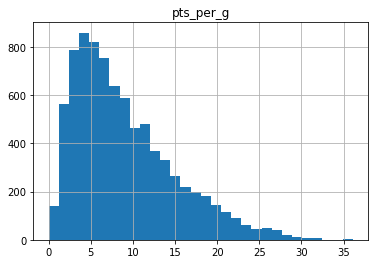

In [78]:
all_player_data.hist(column="pts_per_g",bins=30)

array([[<AxesSubplot:title={'center':'pts_per_g'}>]], dtype=object)

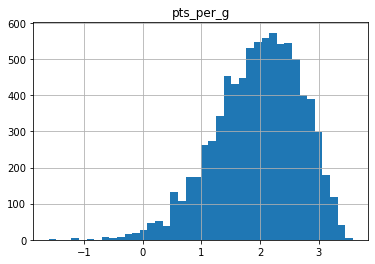

In [94]:
log_player_data=np.log(all_player_data)
log_player_data[log_player_data["pts_per_g"]!=-np.inf].hist(column="pts_per_g",bins=40)

As we can see from the two histograms above the log of pts per game might be better to make predictions (after normalizing) as it is closer to a normal distribution. Although clearly it is still a distribution that has many outliers but now they are to the left opposed to the right for our original data.

array([[<AxesSubplot:title={'center':'mp_per_g'}>]], dtype=object)

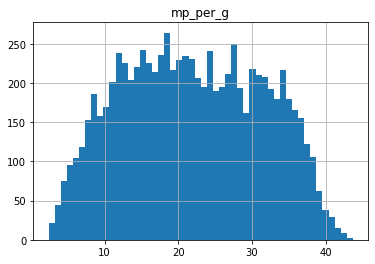

In [102]:
all_player_data.hist(column="mp_per_g",bins=50)

As we can see from the histogram above minutes played (mp_per_game) per game is closer to a normal distribution and has more simmetry to it. These stats (normalized) would work out well to make predictions.

We won't look at the histograms of field goals per game or triples per game as we may expect them to be closely related to the points per game and thus have similar distributions (skewed to the left). So we will now look at (total) rebounts per game (trb_per_g) and at games started (gs)

array([[<AxesSubplot:title={'center':'trb_per_g'}>]], dtype=object)

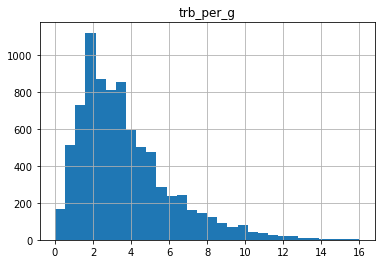

In [104]:
all_player_data.hist(column="trb_per_g",bins=30)

array([[<AxesSubplot:title={'center':'gs'}>]], dtype=object)

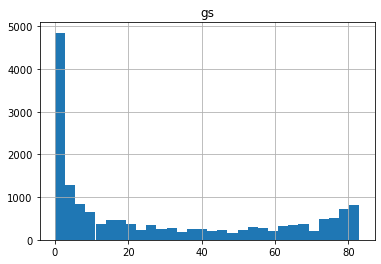

In [105]:
all_player_data.hist(column="gs",bins=30)

As we can see rebounds has a similar shape to that of pts per game, while games started has a pretty unique distribution that is more loaded at both ends. This might be better to use as is (normalized) and think of it to be similar to a binary distribution. 

## Team data

We will now study similar statistics for teams and compare this distributions and decide on the best way to normalize our data.

In [108]:
stats=["fg", "pts", "orb", "drb", "trb", "ast", "stl", "blk", "fg3"]
all_team_data=find(team_tables, "all")[stats]

array([[<AxesSubplot:title={'center':'pts'}>]], dtype=object)

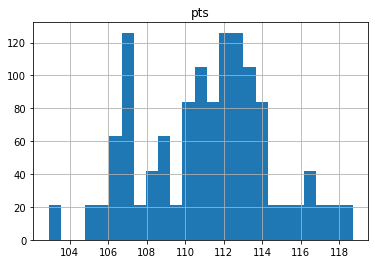

In [122]:
all_team_data.hist(column=["pts"], bins=25)

array([[<AxesSubplot:title={'center':'trb'}>]], dtype=object)

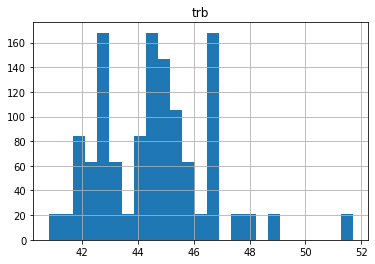

In [121]:
all_team_data.hist(column=["trb"], bins=25)

array([[<AxesSubplot:title={'center':'stl'}>]], dtype=object)

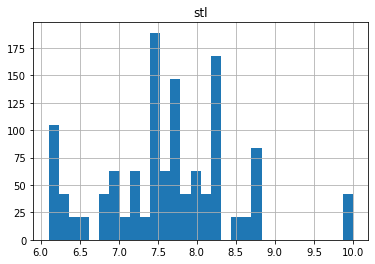

In [125]:
all_team_data.hist(column=["stl"], bins=30)

Looking at the histograms above we see that the distributions for team data are less "nice" and we might expect the predictions made with team data to be less accurate. I decided that for these distributions as they do not seem partticularly skewed to any side and due to their irregularities to normalize from the data as is.

# Normalized predictions

Now that we have decided how to normalize our data lets do a new prediction now that means are adjusted to 0 and standard deviation is set to 1.

In [ ]:
player_stats=["gs", "mp_per_g", "blk_per_g"] #blocks is also skewed but even log is skewed so I feel like is better to not use a transformation in that case
player_log_stats=["fg_per_g", "age", "pts_per_g", "orb_per_g", "drb_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "fg3_per_g"]
team_stats=["fg", "pts", "orb", "drb", "trb", "ast", "stl", "blk", "fg3"]

#to decide which were log and which not, I did look at all tables but I felt it wouldn't be as insightful to go over everything above.

In [ ]:
def normalize():
    """
    data a pandas dataframe that we want to normalize.

    This function will normalize the data and will also return functions to "denormalize" the data back to normal.

    returns normalized_data, denormalizers  normalized data is the normalized data and denormalizers is a dictionary that contains the inverse functions for every column of data
    """